In [ ]:
pip install -U kaleido

In [1]:
pip install omnixai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.2/528.2 kB 814.7 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.6/756.6 kB 3.6 MB/s eta 0:00:00a 0:00:01
  Created wheel for hnswlib: filename=hnswlib-0.6.2-cp37-cp37m-linux_x86_64.whl size=2160903 sha256=da2a54d660e2975a4b61880af2b39ce2f4c8900cd432bd0f1230aac68aa442fb
  Stored in directory: /root/.cache/pip/wheels/67/01/80/9805daef8cd398ceb20003af220f77c4689cab8e43d466481b
Successfully built hnswlib
Note: you may need to restart the kernel to use updated packages.


In [5]:

import os
import sklearn
import xgboost
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import MACEExplainer
import plotly.io as pio
pio.renderers.default = "png"
import io

In [20]:
def explain_classification_model(data_path, target_column, ignored_features,categorical_columns,encode_categorical=False,plot=False):
    data = pd.read_csv(data_path)
    if encode_categorical:
        le = preprocessing.LabelEncoder()
        for col in categorical_columns:
            data[col] = le.fit_transform(data[col])
    feature_names = list(data.columns)
    
    tabular_data = Tabular(
        data,
        feature_columns=feature_names,
        target_column=target_column
    )

    np.random.seed(1)
    transformer = TabularTransform().fit(tabular_data)
    class_names = transformer.class_names
    x = transformer.transform(tabular_data)
    train, test, labels_train, labels_test = \
        sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.80)

    gbtree = xgboost.XGBClassifier(n_estimators=300, max_depth=5)
    gbtree.fit(train, labels_train)

    predict_function=lambda z: gbtree.predict_proba(transformer.transform(z))

    explainer = MACEExplainer(
        training_data=tabular_data,
        predict_function=predict_function,
        ignored_features=ignored_features
    )
    test_instances = tabular_data.remove_target_column()[0:10]
    explanations = explainer.explain(test_instances)
    
    if plot:
        buf = io.BytesIO()
        explanations.ipython_plot(index=1, class_names=class_names, renderer=buf)
        #pio.display(pio.Image(buf.getvalue()))

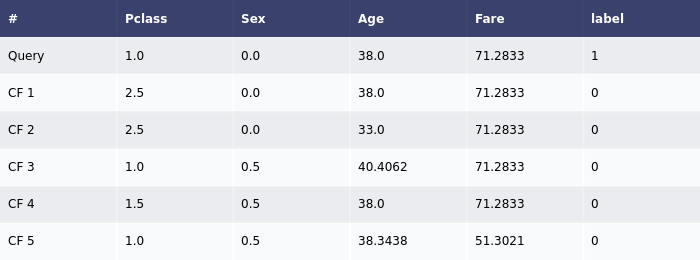

In [21]:
# Titanic dataset 
data_path = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'
target_column = 'Survived'
ignored_features = ['PassengerId', 'Name', 'Ticket', 'Cabin']
categorical_columns=['Name','Sex']
explain_classification_model(data_path, target_column, ignored_features, categorical_columns,plot=True,encode_categorical=True)

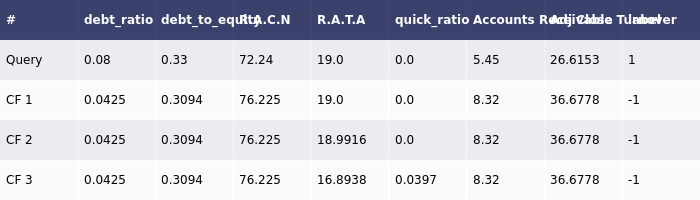

In [19]:
#Fintech Data
data_path = '/kaggle/input/fintech/Processed_FD3.csv'
target_column = 'Label'
ignored_features = ["tic",'PB','Open', 'Volume']
categorical_columns=["tic"]
explain_classification_model(data_path, target_column, ignored_features, categorical_columns,plot=True,encode_categorical=True)